# Objective:
1. Predict the number of purchases a customer will do in 2018 H2.
2. Predict the total cash credited by the customer in 2018 H2.

In [1]:
%pylab inline

import seaborn as sns
import pandas as pd
import lifetimes

Populating the interactive namespace from numpy and matplotlib


In [2]:
np.random.seed(42)

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8) 
plt.rcParams["figure.dpi"] = 60 

# sns.set(style="ticks")
# sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})

# ModifiedBetaGeoFitter
- With this technique, we are abstracting:
  - the nature of the items in the order
  - the ratings of the users in the order
  - the credit payment history of the items in the user
  - the freight rate

In [3]:
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
order_items = pd.read_csv("olist_order_items_dataset.csv")

cols = ['customer_id', 'order_id', 'order_purchase_timestamp']
orders = orders[cols]
orders = orders.set_index('customer_id')
orders.drop_duplicates(inplace=True)
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])

# aggregate cost of items
costs = order_items.groupby("order_id")["price"].sum()

cols = ['customer_id', 'customer_unique_id']
customers = customers[cols]
customers = customers.set_index('customer_id')

transactions = pd.concat([orders,customers], axis=1, join='inner')
transactions.reset_index(inplace=True)

cols = ['customer_unique_id', 'order_id','order_purchase_timestamp']
transactions = transactions[cols]

transactions['order_purchase_timestamp'] = pd.to_datetime(transactions['order_purchase_timestamp'])
transactions['order_date'] = transactions.order_purchase_timestamp.dt.date
transactions['order_date'] = pd.to_datetime(transactions['order_date'])

cols = ['customer_unique_id', 'order_id', 'order_date']
transactions = transactions[cols]

In [4]:
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")

In [5]:
transactions = transactions.merge(costs.to_frame("total_cost").reset_index(), on='order_id')
transactions.columns = ["customer_id", "order_id", "order_date", "total_cost"]

plot number of orders each day

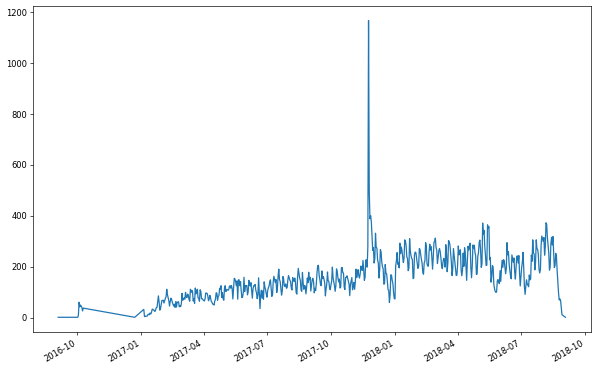

In [6]:
transactions.order_date.value_counts().plot()

Average number of purchases: 1.03
Average number of items bought per customer: 1.07


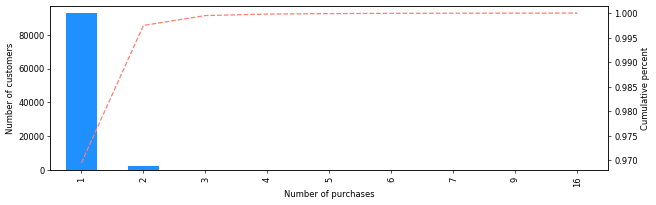

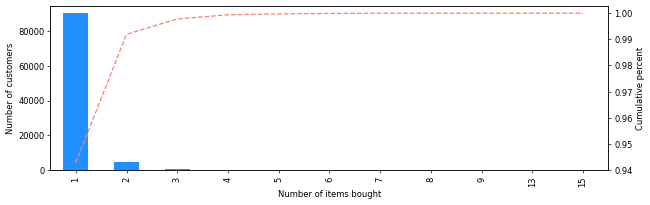

In [7]:
vc_num_purchases_by_customer = transactions.groupby("customer_id")["order_id"].nunique().value_counts()
vc_num_purchases_by_customer = vc_num_purchases_by_customer.sort_index()
nunique_items_per_customer = transactions.merge(order_items).groupby("customer_id")["product_id"].nunique()
vc_num_items_per_customer = nunique_items_per_customer.value_counts()
vc_num_items_per_customer = vc_num_items_per_customer.sort_index()

print("Average number of purchases: {:.2f}".format(transactions.groupby("customer_id")["order_id"].nunique().mean()))
print("Average number of items bought per customer: {:.2f}".format(
    nunique_items_per_customer.mean()))


# plot of number of orders per customer
ax = plt.figure().add_subplot(211)
vc_num_purchases_by_customer.plot.bar(color='dodgerblue', ax=ax)

pct_cumsum_vc = vc_num_purchases_by_customer.cumsum() / vc_num_purchases_by_customer.sum()

ax2=ax.twinx()
ax.set_ylabel("Number of customers")
ax.set_xlabel("Number of purchases")
ax2.set_ylabel("Cumulative percent")
ax2.plot(range(len(vc_num_purchases_by_customer)), pct_cumsum_vc, linestyle='--', color='salmon')

# plot of number of items bought per customer
ax = plt.figure().add_subplot(212)
vc_num_items_per_customer.plot.bar(color='dodgerblue', ax=ax)

pct_cumsum_vc = vc_num_items_per_customer.cumsum() / vc_num_items_per_customer.sum()

ax2=ax.twinx()
ax.set_ylabel("Number of customers")
ax.set_xlabel("Number of items bought")
ax2.set_ylabel("Cumulative percent")
ax2.plot(range(len(vc_num_items_per_customer)), pct_cumsum_vc, linestyle='--', color='salmon')

In [8]:
np.max(transactions.order_date) - np.min(transactions.order_date)

Timedelta('729 days 00:00:00')

In [6]:
from lifetimes.utils import calibration_and_holdout_data

calibration_period_ends = '2018-06-30'

summary_cal_holdout = calibration_and_holdout_data(transactions, 
                                                   customer_id_col = 'customer_id', 
                                                   datetime_col = 'order_date', 
                                                   freq = 'D',
                                        calibration_period_end=calibration_period_ends,
                                        observation_period_end='2018-09-28', monetary_value_col='total_cost' )

In [10]:
summary_cal_holdout[:2]

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,51.0,0.0,0.0,0.0,90.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,54.0,0.0,0.0,0.0,90.0


# NBD Model

In [7]:
from lifetimes import BetaGeoFitter, ModifiedBetaGeoFitter
mbgf = ModifiedBetaGeoFitter()
mbgf.fit(summary_cal_holdout["frequency_cal"], summary_cal_holdout["recency_cal"], summary_cal_holdout["T_cal"], 
         iterative_fitting=3, verbose=True)

Optimization terminated successfully.
         Current function value: 0.078837
         Iterations: 56
         Function evaluations: 58
         Gradient evaluations: 58


<lifetimes.ModifiedBetaGeoFitter: fitted with 83128 subjects, a: 8.12, alpha: 108.46, b: 0.92, r: 0.24>

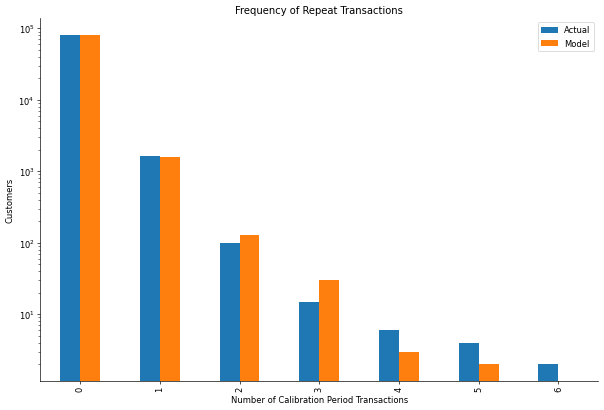

In [12]:
from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbgf, max_frequency=7)
ax.set_yscale('log')
sns.despine();

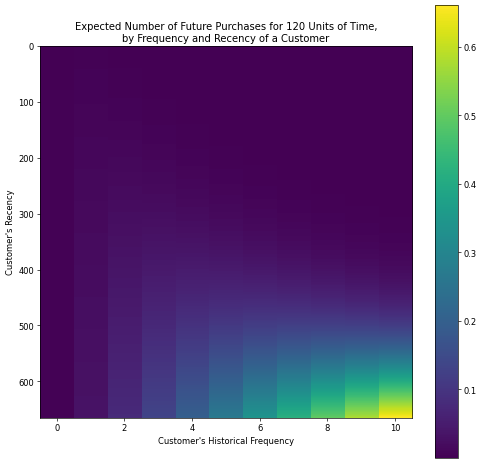

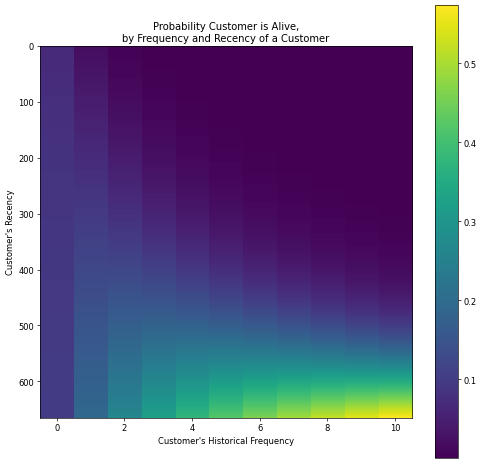

In [13]:
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_expected_repeat_purchases


plt.figure(figsize=(10, 10))
plot_frequency_recency_matrix(mbgf, T=120, );

plt.figure(figsize=(10, 10))
plot_probability_alive_matrix(mbgf);

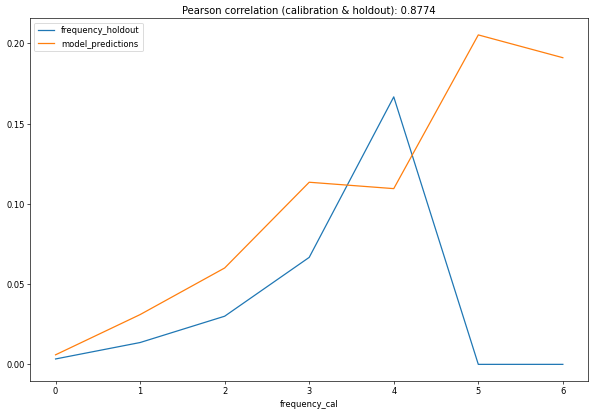

In [17]:
n = 7

summary = summary_cal_holdout.copy()
duration_holdout = summary.iloc[0]['duration_holdout']

summary['model_predictions'] = summary.apply(lambda r: mbgf.conditional_expected_number_of_purchases_up_to_time(
    duration_holdout, r['frequency_cal'], r['recency_cal'], r['T_cal']), axis=1)
agg_data = summary.groupby("frequency_cal")[['frequency_holdout', 'model_predictions']].mean()
ax = agg_data.iloc[:n].plot(title="Pearson correlation (calibration & holdout): {:.4f}".format(agg_data.corr().min().min()))
ax.set_xticks(agg_data.iloc[:n].index);

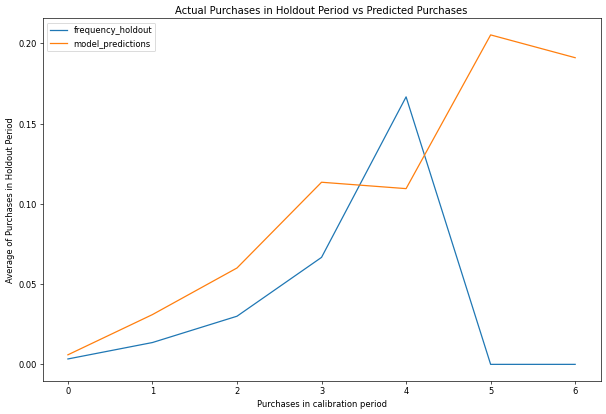

In [85]:
lifetimes.plotting.plot_calibration_purchases_vs_holdout_purchases(mbgf, summary)

In [15]:
t = 120
predicted_purchases = mbgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                               summary_cal_holdout['frequency_cal'], 
                                                                               summary_cal_holdout['recency_cal'],
                                                                               summary_cal_holdout['T_cal'])
predicted_purchases.sort_values().tail(4)

customer_id
fe81bb32c243a86b2f86fbf053fe6140    0.323113
ca77025e7201e3b30c44b472ff346268    0.413244
6469f99c1f9dfae7733b25662e7f1782    0.426639
8d50f5eadf50201ccdcedfb9e2ac8455    0.563370
dtype: float64

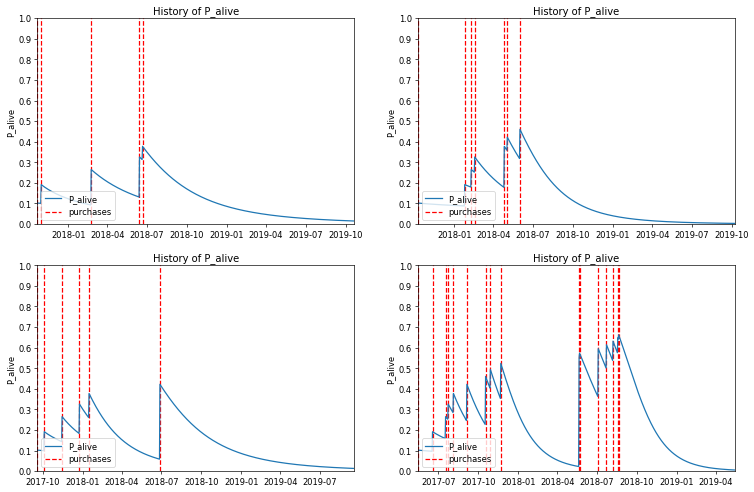

In [16]:
from lifetimes.plotting import plot_history_alive

fig = plt.figure(figsize=(15, 10))

for idx, customer_id in enumerate(predicted_purchases.sort_values().tail(4).index, 1):
    # all days
    days_since_birth = (max(transactions.order_date - min(transactions.order_date))).days
    sp_trans = transactions.loc[transactions['customer_id'] == customer_id]
    
    plot_history_alive(mbgf, days_since_birth, sp_trans, 'order_date', ax=fig.add_subplot(2, 2, idx))

# Adding Monetary, GammaGamma Filter

                    frequency_cal  monetary_value_cal
frequency_cal            1.000000           -0.003018
monetary_value_cal      -0.003018            1.000000


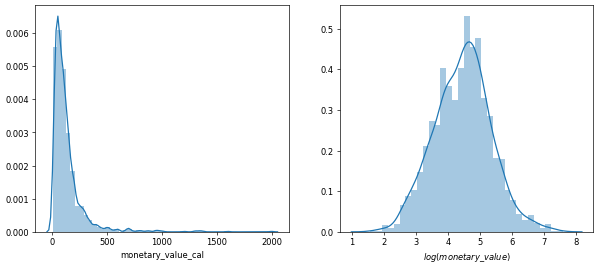

In [8]:
# weak correlation between monetary and frequency
returning_customers_summary = summary_cal_holdout[summary_cal_holdout["frequency_cal"] > 0]
print(returning_customers_summary[["frequency_cal", "monetary_value_cal"]].corr())

fig, axes = plt.subplots(1,2,figsize=(12, 5))
sns.distplot(returning_customers_summary["monetary_value_cal"], ax=axes[0], )
sns.distplot(np.log(returning_customers_summary["monetary_value_cal"] + 1), ax=axes[1], axlabel='$log(monetary\_value)$')

In [9]:
from lifetimes import GammaGammaFitter

gg = GammaGammaFitter()
gg.fit(returning_customers_summary["frequency_cal"], 
       returning_customers_summary["monetary_value_cal"], verbose=True)

Optimization terminated successfully.
         Current function value: 5.761552
         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29


<lifetimes.GammaGammaFitter: fitted with 1745 subjects, p: 2.70, q: 3.00, v: 96.25>

In [10]:
expected_average_profit_validation = gg.conditional_expected_average_profit(
    returning_customers_summary['frequency_holdout'], returning_customers_summary['monetary_value_holdout'])

expected_average_profit = gg.conditional_expected_average_profit(
    returning_customers_summary['frequency_cal'], returning_customers_summary['monetary_value_cal'])

print("Repeat buyers only")
print("Train correlation")
print(pd.Series.corr(returning_customers_summary["monetary_value_cal"], expected_average_profit).round(4))

print("Validation correlation")
print(pd.Series.corr(returning_customers_summary["monetary_value_holdout"], expected_average_profit_validation).round(4))

Repeat buyers only
Train correlation
0.9981
Validation correlation
0.3564


In [11]:
expected_average_profit_validation = gg.conditional_expected_average_profit(
    summary_cal_holdout['frequency_holdout'], summary_cal_holdout['monetary_value_holdout'])

expected_average_profit = gg.conditional_expected_average_profit(
    summary_cal_holdout['frequency_cal'], summary_cal_holdout['monetary_value_cal'])

print("With non-repeat buyers")
print("Train correlation")
print(pd.Series.corr(summary_cal_holdout["monetary_value_cal"], expected_average_profit).round(4))

print("Validation correlation")
print(pd.Series.corr(summary_cal_holdout["monetary_value_holdout"], expected_average_profit_validation).round(4))

With non-repeat buyers
Train correlation
0.7687
Validation correlation
0.6719


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(summary_cal_holdout["monetary_value_holdout"], expected_average_profit_validation)

129.29340317032162

In [24]:
print("Expected average profit validation: {:.2f}, Average profit validation: {:.2f}".format(
    gg.conditional_expected_average_profit(
        summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['monetary_value_cal']
    ).mean(),
    summary_cal_holdout[summary_cal_holdout['frequency_cal']>0]['monetary_value_cal'].mean()))

Expected average profit validation: 129.63, Average profit validation: 129.45


In [94]:
summary_cal_holdout[summary_cal_holdout['frequency_cal']>0]['monetary_value_cal']

customer_id
004288347e5e88a27ded2bb23747066c    87.900 
004b45ec5c64187465168251cd1c9c2f    27.000 
0058f300f57d7b93c477a131a59b36c3    72.580 
00a39521eb40f7012db50455bf083460    11.550 
011575986092c30523ecb71ff10cb473    63.900 
                                     ...   
fe81bb32c243a86b2f86fbf053fe6140    369.850
fed519569d16e690df6f89cb99d4e682    89.900 
ff03923ad1eb9e32304deb7f9b2a45c9    110.320
ff8892f7c26aa0446da53d01b18df463    49.950 
ff922bdd6bafcdf99cb90d7f39cea5b3    34.945 
Name: monetary_value_cal, Length: 1745, dtype: float64

In [14]:
customer_CLV = gg.customer_lifetime_value(
    mbgf, #the model to use to predict the number of future transactions
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal'],
    summary_cal_holdout['monetary_value_cal'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)
print(customer_CLV)

customer_id
0000366f3b9a7992bf8c76cfdf3221e2    3.155163
0000b849f77a49e4a4ce2b2a4ca5be3f    3.109756
0000f46a3911fa3c0805444483337064    0.981497
0000f6ccb0745a6a4b88665a16c9f078    1.536583
0004aac84e0df4da2b147fca70cf8255    1.675681
                                      ...   
fffcf5a5ff07b0908bd4e2dbc735a684    1.159364
fffea47cd6d3cc0a88bd621562a9d061    1.802978
ffff371b4d645b6ecea244b27531430a    0.931434
ffff5962728ec6157033ef9805bacc48    3.036867
ffffd2657e2aad2907e67c3e9daecbeb    1.079551
Name: clv, Length: 83128, dtype: float64


In [18]:
with pd.ExcelWriter('cusomter_clv.xlsx') as writer:
    customer_CLV.to_excel(writer, sheet_name='CLV')


# Conclusions:
- Repeat purchases could be predicted (holdout set's pearson correlation with predictions) although the probability is very low (expected number of future purchases).
- Monetary value predictions has good correlation although this includes the non-repeat buyers. 
- For the repeat buyers, monetary value predictions' correlation is low. The exact monetary value is hard to predict since for an e-commerce site, the variety of items is very large.

# Regression with item types
## Target: Frequency Holdout
Not good!

In [25]:
returning_customers_summary[:2]

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,338.0,87.9,0.0,0.0,90.0
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,302.0,27.0,0.0,0.0,90.0


In [26]:
from sklearn.model_selection import train_test_split

train_cols = ["frequency_cal", "recency_cal", "T_cal", "monetary_value_cal"]
X_train = returning_customers_summary[train_cols].values
y_train = returning_customers_summary["frequency_cal"].values

test_cols = ["frequency_cal", "recency_cal", "T_cal", "monetary_value_holdout"]
X_test = returning_customers_summary[test_cols].values
y_test = returning_customers_summary["frequency_holdout"].values

In [27]:
import statsmodels.api as sm

X_train_constant = sm.add_constant(X_train, prepend=False)

mod = sm.OLS(y_train, X_train_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.549e+30
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:50:08   Log-Likelihood:                 54906.
No. Observations:                1745   AIC:                        -1.098e+05
Df Residuals:                    1740   BIC:                        -1.098e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0000   2.71e-16    3.7e+15      0.0

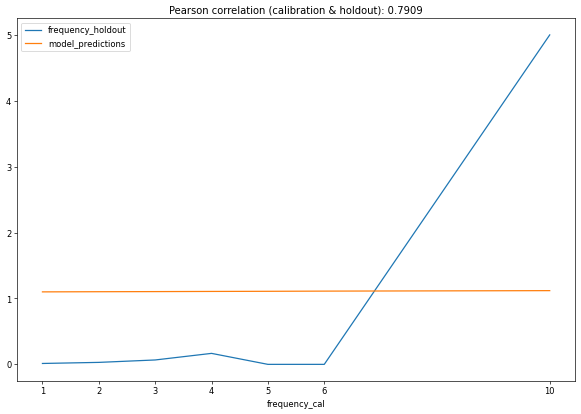

In [28]:
from sklearn.svm import SVR

svr_model = SVR()

svr_model.fit(X_train, y_train)
preds = svr_model.predict(X_test)

n = 30

summary = returning_customers_summary.copy()
duration_holdout = summary.iloc[0]['duration_holdout']

summary['model_predictions'] = preds
agg_data = summary.groupby("frequency_cal")[['frequency_holdout', 'model_predictions']].mean()
ax = agg_data.iloc[:n].plot(title="Pearson correlation (calibration & holdout): {:.4f}".format(agg_data.corr().min().min()))
ax.set_xticks(agg_data.iloc[:n].index);

# Adding the nature of items
- X attributes: 
 - number of items purchased, type of items purchased, city, payment history, type of seller, cost of items, 
- y attributes: how many times the customer returned to purchase an order

In [29]:
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
order_items = pd.read_csv("olist_order_items_dataset.csv")


In [30]:
print("Orders")
display(orders[:2])
print("Customers")
display(customers[:2])
print("Payments")
display(payments[:2])
print("Orders-Items")
display(order_items[:2])
print("Items")
display(products[:2])
print("Sellers")
display(sellers[:2])

Orders


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


Customers


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


Payments


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


Orders-Items


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


Items


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


Sellers


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


In [33]:
import featuretools as ft

es = ft.EntitySet(id = 'customers')

es = es.entity_from_dataframe(entity_id = 'customers', dataframe = customers[["customer_id", "customer_city", "customer_state"]], 
                              index = 'customer_id',)

es = es.entity_from_dataframe(entity_id = 'orders', dataframe = orders.reset_index(),
                              index = 'order_id', 
                              time_index = 'order_purchase_timestamp')

es = es.entity_from_dataframe(entity_id = 'order_products', 
                              dataframe = order_items[["order_id", "product_id", "seller_id", "price", "freight_value"]],
                              index = 'order_product_id', make_index=True)

es = es.entity_from_dataframe(entity_id = 'products', 
                              dataframe = products,
                              index = 'product_id', )

es = es.entity_from_dataframe(entity_id = 'sellers', 
                              dataframe = sellers[["seller_id", "seller_city", "seller_state"]],
                              index = 'seller_id', )

es = es.entity_from_dataframe(entity_id = 'payments', 
                              dataframe = payments[["order_id", "payment_type", "payment_installments", "payment_value"]],
                              index = 'payment_id', make_index=True)

In [34]:
# Add the relationship to the entity set
# customer to orders
es = es.add_relationship(ft.Relationship(es['customers']['customer_id'],
                                    es['orders']['customer_id']))
# orders to order products
es = es.add_relationship(ft.Relationship(es['orders']['order_id'],
                                    es['order_products']['order_id']))
# products to order products
es = es.add_relationship(ft.Relationship(es['products']['product_id'], 
                                         es['order_products']['product_id']))
# sellers to order products
es = es.add_relationship(ft.Relationship(es['sellers']['seller_id'],
                                         es['order_products']['seller_id']))

# orders to payments
es = es.add_relationship(ft.Relationship(es['orders']['order_id'],
                                         es['payments']['order_id']))


In [35]:
es.add_last_time_indexes()

In [36]:
es

Entityset: customers
  Entities:
    customers [Rows: 99441, Columns: 3]
    orders [Rows: 99441, Columns: 9]
    order_products [Rows: 112650, Columns: 6]
    products [Rows: 32951, Columns: 9]
    sellers [Rows: 3095, Columns: 3]
    payments [Rows: 103886, Columns: 5]
  Relationships:
    orders.customer_id -> customers.customer_id
    order_products.order_id -> orders.order_id
    order_products.product_id -> products.product_id
    order_products.seller_id -> sellers.seller_id
    payments.order_id -> orders.order_id

In [37]:
# We want to know if the customer will buy anything again after cutoff
cutoff_time = pd.Timestamp('July 1, 2018')

# 60 days

In [38]:
# training window of only 2 months, then experiment with 4 months, 6 months
# find out if the customer will buy anything after 
# turns out, sliding windows are not supported yet
features, feature_names = ft.dfs(entityset = es, target_entity = 'customers', verbose=True, 
                                 cutoff_time=cutoff_time,
                                 training_window = ft.Timedelta("60 days"))

Built 261 features
Elapsed: 01:55 | Progress: 100%|██████████


In [40]:
import missingno as msno
features_null_filtered = msno.nullity_filter(features, p=0.75)

In [41]:
features_encoded, features_names_encoded = ft.encode_features(features_null_filtered, feature_names)

# Regression, finally

In [42]:
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
last_timestamp_per_customer = orders.reset_index().groupby("customer_id")["order_purchase_timestamp"].max()
customer_bought_after_cutoff = last_timestamp_per_customer > cutoff_time

In [43]:
from sklearn.model_selection import train_test_split

X = features_encoded
y = customer_bought_after_cutoff

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer as Imputer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

imputer = Imputer(strategy='most_frequent')
t_svd = TruncatedSVD(n_components=100)
log_res = LogisticRegression(C=0.1)

pipeline = make_pipeline(imputer, t_svd, log_res)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('truncatedsvd', TruncatedSVD(n_components=100)),
                ('logisticregression', LogisticRegression(C=0.1))])

In [47]:
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score

def complete_evaluation(y_test, y_probs, y_preds, positive_class=1):
    """
    Complete evaluation
    """
    acc = accuracy_score(y_test, y_preds)
    average_prec = average_precision_score(y_test, y_probs[:, positive_class])
    precs, recs, fscore, support = precision_recall_fscore_support(y_test, y_preds)
    prec_0, prec_1 = precs
    rec_0, rec_1 = recs
    fscore_0, fscore_1 = fscore 
    support_0, support_1 = support
    
    balanced_accuracy = (rec_0 + rec_1) / 2

    log_loss_value = log_loss(y_test, y_probs)
    auc_value = roc_auc_score(y_test, y_probs[:, positive_class])

    return pd.DataFrame([{"accuracy" : acc, "loss" : log_loss_value, "auc" : auc_value, "average_precision" : average_prec,
                  "precision_0" : prec_0, "precision_1" : prec_1, 
                  "recall_0" : rec_0, "recall_1" : rec_1, "fscore_0" : fscore_0, "fscore_1" : fscore_1,
                  "support_0" : support_0, "support_1" : support_1, "balanced_accuracy" : balanced_accuracy}])

In [48]:
y_proba = pipeline.predict_proba(X_test)

list_results = []
for threshold in [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]:
    y_preds = y_proba[:, 1] > threshold
    result = complete_evaluation(y_test, y_proba, y_preds)
    result["threshold"] = threshold
    result["number_predictions"] = (y_preds == 1).sum()
    list_results.append(result)
    
df_results_thresholds = pd.concat(list_results)

In [49]:
df_results_thresholds

,accuracy,loss,auc,average_precision,precision_0,precision_1,recall_0,recall_1,fscore_0,fscore_1,support_0,support_1,balanced_accuracy,threshold,number_predictions
0,0.135050,0.389257,0.506663,0.130827,0.865031,0.129018,0.008140,0.991430,0.016128,0.228323,17322,2567,0.499785,0.050,19726
0,0.140630,0.389257,0.506663,0.130827,0.861635,0.128915,0.015818,0.982859,0.031066,0.227934,17322,2567,0.499339,0.075,19571
0,0.153351,0.389257,0.506663,0.130827,0.882726,0.129453,0.032156,0.971173,0.062051,0.228454,17322,2567,0.501664,0.100,19258
0,0.168586,0.389257,0.506663,0.130827,0.880814,0.129607,0.052477,0.952084,0.099052,0.228155,17322,2567,0.502280,0.125,18857
0,0.827040,0.389257,0.506663,0.130827,0.871057,0.131023,0.940654,0.060382,0.904519,0.082667,17322,2567,0.500518,0.150,1183
0,0.834431,0.389257,0.506663,0.130827,0.870686,0.124224,0.951160,0.046747,0.909146,0.067931,17322,2567,0.498954,0.175,966
0,0.842627,0.389257,0.506663,0.130827,0.870432,0.115962,0.962591,0.033113,0.914195,0.051515,17322,2567,0.497852,0.200,733


<Figure size 900x300 with 0 Axes>

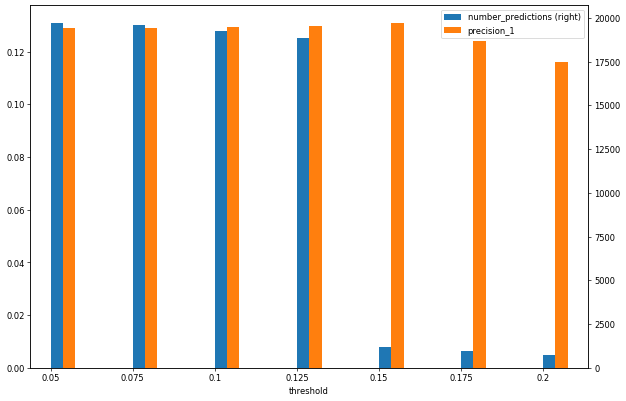

In [50]:
width = 0.3
plt.figure(figsize=(15,5))
df_results_thresholds.plot(y=['number_predictions', "precision_1"], x="threshold", position=0, kind='bar',
                                    width=width, secondary_y= 'number_predictions', rot=0, )

# 120 days

In [51]:
# 120 days training window
features, feature_names = ft.dfs(entityset = es, target_entity = 'customers', verbose=True, 
                                 cutoff_time=cutoff_time,
                                 training_window = ft.Timedelta("120 days"))

Built 261 features
Elapsed: 03:57 | Progress: 100%|██████████


In [52]:
import missingno as msno
features_null_filtered = msno.nullity_filter(features, p=0.75)

In [53]:
features_encoded, features_names_encoded = ft.encode_features(features_null_filtered, feature_names)

# Regression, finally

In [54]:
last_timestamp_per_customer = orders.reset_index().groupby("customer_id")["order_purchase_timestamp"].max()
customer_bought_after_cutoff = last_timestamp_per_customer > cutoff_time

In [55]:
from sklearn.model_selection import train_test_split

X = features_encoded
y = customer_bought_after_cutoff

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
imputer = Imputer(strategy='most_frequent')
t_svd = TruncatedSVD(n_components=100)
log_res = LogisticRegression(C=0.1)

pipeline = make_pipeline(imputer, t_svd, log_res)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('truncatedsvd', TruncatedSVD(n_components=100)),
                ('logisticregression', LogisticRegression(C=0.1))])

In [57]:
y_proba = pipeline.predict_proba(X_test)

list_results = []
for threshold in [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]:
    y_preds = y_proba[:, 1] > threshold
    result = complete_evaluation(y_test, y_proba, y_preds)
    result["threshold"] = threshold
    result["number_predictions"] = (y_preds == 1).sum()
    result["average f-score"] = ((result["fscore_0"] + result["fscore_1"])/2).iloc[0]
    list_results.append(result)
    
df_results_thresholds = pd.concat(list_results)

In [58]:
df_results_thresholds

,accuracy,loss,auc,average_precision,precision_0,precision_1,recall_0,recall_1,fscore_0,fscore_1,support_0,support_1,balanced_accuracy,threshold,number_predictions,average f-score
0,0.138871,0.38935,0.50808,0.129729,0.887097,0.129423,0.012703,0.989105,0.025047,0.228896,17319,2570,0.500904,0.050,19641,0.126971
0,0.147921,0.38935,0.50808,0.129729,0.885892,0.129592,0.024655,0.978599,0.047975,0.228876,17319,2570,0.501627,0.075,19407,0.138425
0,0.163256,0.38935,0.50808,0.129729,0.874862,0.129411,0.045615,0.956031,0.086708,0.227964,17319,2570,0.500823,0.100,18986,0.157336
0,0.195686,0.38935,0.50808,0.129729,0.881640,0.130253,0.088169,0.920233,0.160307,0.228205,17319,2570,0.504201,0.125,18157,0.194256
0,0.770979,0.38935,0.50808,0.129729,0.870057,0.124480,0.866390,0.128016,0.868219,0.126223,17319,2570,0.497203,0.150,2643,0.497221
0,0.804968,0.38935,0.50808,0.129729,0.870330,0.124498,0.911889,0.084436,0.890625,0.100626,17319,2570,0.498162,0.175,1743,0.495625
0,0.832118,0.38935,0.50808,0.129729,0.870272,0.119683,0.948611,0.047082,0.907755,0.067579,17319,2570,0.497847,0.200,1011,0.487667
0,0.851677,0.38935,0.50808,0.129729,0.870622,0.123016,0.974479,0.024125,0.919627,0.040338,17319,2570,0.499302,0.225,504,0.479983
0,0.862135,0.38935,0.50808,0.129729,0.870671,0.119469,0.988510,0.010506,0.925856,0.019313,17319,2570,0.499508,0.250,226,0.472585


<Figure size 900x300 with 0 Axes>

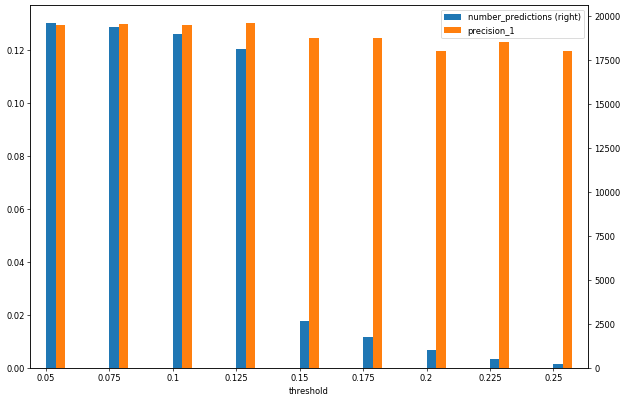

In [59]:
width = 0.3
plt.figure(figsize=(15,5))
df_results_thresholds.plot(y=['number_predictions', "precision_1"], x="threshold", position=0, kind='bar',
                                    width=width, secondary_y= 'number_predictions', rot=0, )

## A more complex model -- Random Forests

In [67]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline

imputer = Imputer(strategy='most_frequent')
random_forest = RandomForestClassifier(n_estimators=50, max_depth=3, min_samples_split=10, 
                                       class_weight='balanced_subsample')
# gbt = GradientBoostingClassifier(subsample=0.5, n_iter_no_change=3, verbose=True,)

pipeline = make_pipeline(imputer, random_forest)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=3, min_samples_split=10,
                                        n_estimators=50))])

In [68]:
def name_scores(featurecoef, col_names, label="Score", sort=False):
    """
    Generates a DataFrame with all the independent variables used in the model with their corresponding coefficient
    :param featurecoef: model.coef_ | model.feature_importances_
    :param column: string to be anonymized
    :param label: Name of the column where coefficients will be added
    :param sort: False = Decending, True = Ascending
    :return: pandas DataFrame
    """
    
    df_feature_importance = pd.DataFrame([dict(zip(col_names, featurecoef))]).T.reset_index()
    df_feature_importance.columns = ["Feature", label]
    if sort:
        return df_feature_importance.sort_values(ascending=False, by=label)
    return df_feature_importance

In [69]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

In [70]:
name_scores(random_forest.feature_importances_, X_train.columns, sort=True)[:20]

,Feature,Score
115,MAX(orders.SUM(order_products.price)),0.031527
154,MIN(orders.MEAN(order_products.price)),0.026527
166,MIN(orders.STD(payments.payment_installments)),0.022208
74,COUNT(payments),0.021778
126,MEAN(orders.MEAN(payments.payment_installments)),0.021486
169,MIN(orders.SUM(order_products.price)),0.021071
150,MIN(orders.MAX(order_products.price)),0.020864
24,MEAN(orders.index),0.019787
408,STD(orders.SUM(payments.payment_installments)),0.018828
96,MAX(orders.MEAN(order_products.price)),0.018457


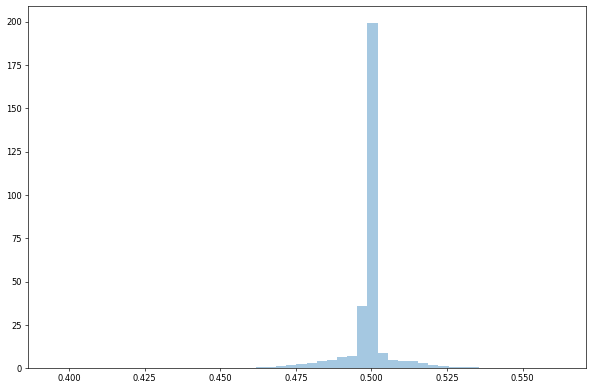

In [71]:
y_proba = pipeline.predict_proba(X_test)
sns.distplot(y_proba[:, 1])

list_results = []
for threshold in [0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65]:
    y_preds = y_proba[:, 1] > threshold
    result = complete_evaluation(y_test, y_proba, y_preds)
    result["threshold"] = threshold
    result["number_predictions"] = (y_preds == 1).sum()
    result["average f-score"] = ((result["fscore_0"] + result["fscore_1"])/2).iloc[0]
    list_results.append(result)
    
df_results_thresholds = pd.concat(list_results)

In [72]:
df_results_thresholds

,accuracy,loss,auc,average_precision,precision_0,precision_1,recall_0,recall_1,fscore_0,fscore_1,support_0,support_1,balanced_accuracy,threshold,number_predictions,average f-score
0,0.780079,0.691867,0.499659,0.129531,0.870047,0.123853,0.878688,0.115564,0.874346,0.119565,17319,2570,0.497126,0.500,2398,0.496956
0,0.863844,0.691867,0.499659,0.129531,0.870932,0.144330,0.990415,0.010895,0.926838,0.020260,17319,2570,0.500655,0.525,194,0.473549
0,0.870632,0.691867,0.499659,0.129531,0.870763,0.000000,0.999827,0.000000,0.930843,0.000000,17319,2570,0.499913,0.550,3,0.465421
0,0.870783,0.691867,0.499659,0.129531,0.870783,0.000000,1.000000,0.000000,0.930929,0.000000,17319,2570,0.500000,0.575,0,0.465464
0,0.870783,0.691867,0.499659,0.129531,0.870783,0.000000,1.000000,0.000000,0.930929,0.000000,17319,2570,0.500000,0.600,0,0.465464
0,0.870783,0.691867,0.499659,0.129531,0.870783,0.000000,1.000000,0.000000,0.930929,0.000000,17319,2570,0.500000,0.625,0,0.465464
0,0.870783,0.691867,0.499659,0.129531,0.870783,0.000000,1.000000,0.000000,0.930929,0.000000,17319,2570,0.500000,0.650,0,0.465464


<Figure size 900x300 with 0 Axes>

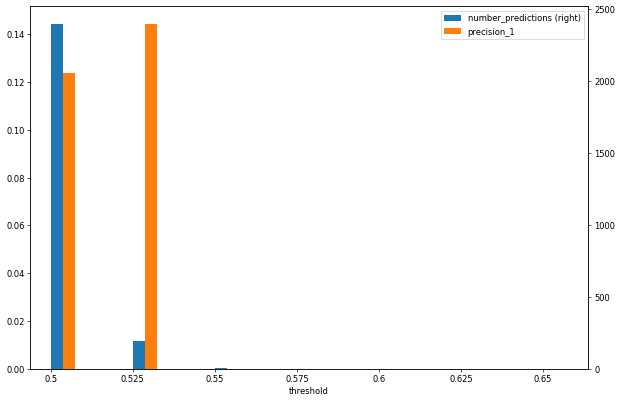

In [73]:
width = 0.3
plt.figure(figsize=(15,5))
df_results_thresholds.plot(y=['number_predictions', "precision_1"], x="threshold", position=0, kind='bar',
                                    width=width, secondary_y= 'number_predictions', rot=0, )

## Gradient Boosted Trees

In [ ]:
imputer = Imputer(strategy='most_frequent')
gbt = GradientBoostingClassifier(verbose=True,)

pipeline = make_pipeline(imputer, gbt)
pipeline.fit(X_train, y_train)

In [ ]:
name_scores(gbt.feature_importances_, X_train.columns, sort=True)[:20]

In [ ]:
y_proba = pipeline.predict_proba(X_test)
sns.distplot(y_proba[:, 1])

list_results = []
for threshold in [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]:
    y_preds = y_proba[:, 1] > threshold
    result = complete_evaluation(y_test, y_proba, y_preds)
    result["threshold"] = threshold
    result["number_predictions"] = (y_preds == 1).sum()
    result["average f-score"] = ((result["fscore_0"] + result["fscore_1"])/2).iloc[0]
    list_results.append(result)
    
df_results_thresholds = pd.concat(list_results)

In [ ]:
df_results_thresholds

In [ ]:
width = 0.3
plt.figure(figsize=(15,5))
df_results_thresholds.plot(y=['number_predictions', "precision_1"], x="threshold", position=0, kind='bar',
                                    width=width, secondary_y= 'number_predictions', rot=0, )